In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [2]:
# Constants
NUM_RUNS = 100
NUM_EPISODES = 1000
GAMMA = 1.0
OPTIMAL_VALUE = -11.6  # approximated from the text / known result
ALPHA_THETA_NO_BASELINE = 2**-13
ALPHA_THETA_BASELINE = 2**-9
ALPHA_W_BASELINE = 2**-6

# Environment constants
LEFT_END = 0
RIGHT_END = 7
ACTION_UP = 0
ACTION_DOWN = 1
ACTIONS = [ACTION_UP, ACTION_DOWN]

# Seeding for reproducibility
RNG_SEEDS = np.arange(NUM_RUNS)


In [3]:
class ShortCorridorEnv:
    """
    Short corridor environment (Example 13.1).
    States: integer positions from 0 (start) to 10 (goal).
    Actions: UP (0) and DOWN (1), but they don't move as expected:
        UP: 80% chance move LEFT, 20% chance move RIGHT
        DOWN: 80% chance move RIGHT, 20% chance move LEFT
    The agent starts at S0. The episode ends when S10 is reached.
    Reward: -1 per step until the goal is reached.
    """
    def __init__(self, seed=None):
        self.state = LEFT_END
        self.rng = np.random.RandomState(seed)

    def reset(self):
        self.state = LEFT_END
        return self.state

    def step(self, action):
        # Probabilities of moving right or left depend on action
        if action == ACTION_UP:
            # 80% left, 20% right
            move_left_prob = 0.8
        else:
            # action DOWN: 80% right, 20% left
            move_left_prob = 0.2
        
        if self.rng.rand() < move_left_prob:
            next_state = max(LEFT_END, self.state - 1)
        else:
            next_state = min(RIGHT_END, self.state + 1)
        
        reward = -1.0
        done = (next_state == RIGHT_END)
        self.state = next_state
        return self.state, reward, done


In [4]:
class REINFORCEAgent:
    """
    REINFORCE agent without baseline.
    Policy parameterization: preferences for actions from each state are linear
    in state-action features. Here we use a simple representation:
    - We have a single parameter per action because the environment is 1D and small.
    - Policy: π(a|s,θ) = exp(h(a))/Σ_b exp(h(b)) where h(a) = θ[a].
    We do not use state features because each state is effectively distinct and small.
    For simplicity, we store preferences separately for each state-action pair.
    However, from the textbook example, a minimal representation can also be used:
    It's known that only the start state's parameterization really matters for this example.
    But we implement fully general approach.

    Step-size: α for θ.
    """
    def __init__(self, alpha_theta, gamma=1.0, seed=None):
        """Initialize with given step size for policy."""
        self.gamma = gamma
        self.alpha = alpha_theta
        self.rng = np.random.RandomState(seed)
        # We have 11 states (0 to 10), 2 actions
        self.theta = np.zeros((RIGHT_END+1, len(ACTIONS)))
    
    def policy(self, state):
        """Compute policy distribution π(.|state)."""
        prefs = self.theta[state]
        max_pref = np.max(prefs)
        # softmax stable implementation
        exp_prefs = np.exp(prefs - max_pref)
        return exp_prefs / np.sum(exp_prefs)
    
    def select_action(self, state):
        """Select action according to current policy."""
        probs = self.policy(state)
        return self.rng.choice(ACTIONS, p=probs)
    
    def update(self, episode):
        """
        After an episode: episode is a list of (S_t, A_t, R_{t+1}) until terminal.
        REINFORCE update:
        θ <- θ + α * Σ_t G_t ∇ ln π(A_t|S_t)
        """
        # First compute returns G_t
        states, actions, rewards = zip(*episode)
        T = len(states)
        returns = np.zeros(T)
        G = 0.0
        for t in reversed(range(T)):
            G = rewards[t] + self.gamma * G
            returns[t] = G
        
        # Update θ
        for t in range(T):
            s, a = states[t], actions[t]
            probs = self.policy(s)
            grad_log = -probs
            grad_log[a] += 1.0  # derivative w.r.t. logits => x(a)-sum(prob*b features), features are one-hot here
            # Since features are trivial (one-hot action), this is basically the vector form:
            # ∇_θ(a) ln π(A_t|S_t) = 1 - π(A_t|S_t) for the chosen action dimension and -π(b|S_t) for others.
            self.theta[s] += self.alpha * returns[t] * grad_log


In [5]:
class REINFORCEWithBaselineAgent:
    """
    REINFORCE with a state-value baseline.
    Baseline: v_hat(s,w) = w (a single parameter; per the textbook example)
    Update rules:
    w <- w + α^w (G_t - v_hat(S_t,w)) ∇ v_hat(S_t,w)
    θ <- θ + α^θ (G_t - v_hat(S_t,w)) ∇ ln π(A_t|S_t)
    
    Here ∇v_hat(s,w) = 1 (since v_hat(s,w)=w is just a constant baseline).
    """
    def __init__(self, alpha_theta, alpha_w, gamma=1.0, seed=None):
        self.gamma = gamma
        self.alpha_theta = alpha_theta
        self.alpha_w = alpha_w
        self.rng = np.random.RandomState(seed)
        # Policy parameters
        self.theta = np.zeros((RIGHT_END+1, len(ACTIONS)))
        # Baseline parameter (single scalar)
        self.w = 0.0
    
    def policy(self, state):
        prefs = self.theta[state]
        max_pref = np.max(prefs)
        exp_prefs = np.exp(prefs - max_pref)
        return exp_prefs / np.sum(exp_prefs)
    
    def select_action(self, state):
        probs = self.policy(state)
        return self.rng.choice(ACTIONS, p=probs)
    
    def v_hat(self, state):
        return self.w  # baseline is a constant w
    
    def update(self, episode):
        states, actions, rewards = zip(*episode)
        T = len(states)
        returns = np.zeros(T)
        G = 0.0
        for t in reversed(range(T)):
            G = rewards[t] + self.gamma * G
            returns[t] = G
        
        for t in range(T):
            s, a = states[t], actions[t]
            delta = returns[t] - self.v_hat(s)
            
            # Update w
            self.w += self.alpha_w * delta  # gradient of v_hat w.r.t w is 1
            
            # Update theta
            probs = self.policy(s)
            grad_log = -probs
            grad_log[a] += 1.0
            self.theta[s] += self.alpha_theta * delta * grad_log


In [6]:
def run_experiment(seed, agent_type='no_baseline'):
    """
    Run one run (with a fixed seed) of 1000 episodes and return the array of G_0 returns.
    """
    env = ShortCorridorEnv(seed=seed)
    if agent_type == 'no_baseline':
        agent = REINFORCEAgent(alpha_theta=ALPHA_THETA_NO_BASELINE, gamma=GAMMA, seed=seed)
    else:
        agent = REINFORCEWithBaselineAgent(alpha_theta=ALPHA_THETA_BASELINE, alpha_w=ALPHA_W_BASELINE, gamma=GAMMA, seed=seed)
    
    returns = np.zeros(NUM_EPISODES)
    for i in range(NUM_EPISODES):
        s = env.reset()
        episode = []
        done = False
        while not done:
            a = agent.select_action(s)
            s_next, r, done = env.step(a)
            episode.append((s, a, r))
            s = s_next
        
        # Update agent at the end of the episode
        agent.update(episode)
        returns[i] = np.sum([step[2] for step in episode])  # total return G_0 in this episode
    
    return returns


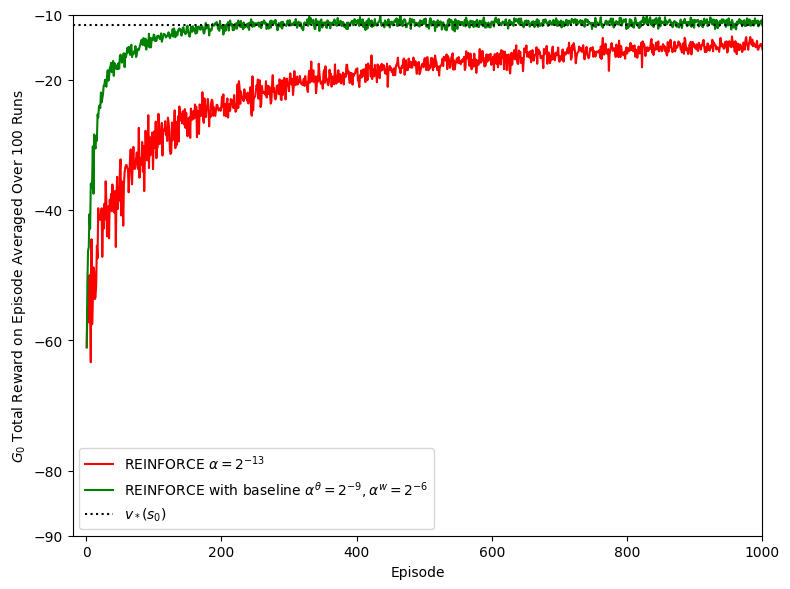

In [7]:
def main():
    # Run experiments in parallel
    # REINFORCE no baseline
    returns_no_baseline_all = Parallel(n_jobs=-1)(delayed(run_experiment)(seed, 'no_baseline') for seed in RNG_SEEDS)
    returns_no_baseline_all = np.array(returns_no_baseline_all)
    mean_returns_no_baseline = returns_no_baseline_all.mean(axis=0)
    
    # REINFORCE with baseline
    returns_with_baseline_all = Parallel(n_jobs=-1)(delayed(run_experiment)(seed, 'with_baseline') for seed in RNG_SEEDS)
    returns_with_baseline_all = np.array(returns_with_baseline_all)
    mean_returns_with_baseline = returns_with_baseline_all.mean(axis=0)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8,6))

    # X axis: Episode 1 to 1000
    episodes = np.arange(1, NUM_EPISODES+1)
    ax.plot(episodes, mean_returns_no_baseline, color='red', label='REINFORCE $\\alpha=2^{-13}$')
    ax.plot(episodes, mean_returns_with_baseline, color='green', label='REINFORCE with baseline $\\alpha^{\\theta}=2^{-9}, \\alpha^{w}=2^{-6}$')
    
    # Dotted black line at optimal value
    ax.axhline(y=OPTIMAL_VALUE, color='black', linestyle=':', label='$v_*(s_0)$')
    
    # X-axis
    ax.set_xlabel("Episode")
    ax.set_xlim([-20,1000])
    ax.set_xticks(np.arange(0,1001,200))

    # Y-axis
    ax.set_ylabel("$G_0$ Total Reward on Episode Averaged Over 100 Runs")
    ax.set_yticks([-90, -80, -60, -40, -20, -10])
    ax.set_ylim([-90, -10])

    # Legend
    ax.legend()

    # Title or any additional formatting as per the figure in the text (not explicitly stated but we match figure style)
    # Typically no title on such textbook figures
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
